In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
#loading the dataset from kaggle
!kaggle datasets download phucthaiv02/butterfly-image-classification

Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 54% 122M/226M [00:00<00:00, 1.27GB/s]
100% 226M/226M [00:00<00:00, 857MB/s] 


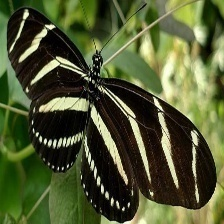

In [ ]:
#displaying images
image1_path = '/content/test/Image_10.jpg'

from IPython.display import Image
Image(image1_path)

In [ ]:
import zipfile
import os

zip_path = '/content/butterfly-image-classification.zip'

# Extracting contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

#   Load CSV
df = pd.read_csv('/content/Training_set.csv')
df['filename'] = df['filename'].astype(str)

# Step 2: Split into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Step 3: Set up paths
image_dir = '/content/train'
img_size = 224
batch_size = 32
num_classes = df['label'].nunique()

# Step 4: Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Step 5: Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

# Step 6: Add custom head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 7: Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.0412 - loss: 4.2916

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 548ms/step - accuracy: 0.0414 - loss: 4.2902 - val_accuracy: 0.3438 - val_loss: 3.4130
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 462ms/step - accuracy: 0.2119 - loss: 3.4119 - val_accuracy: 0.5038 - val_loss: 2.6138
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.3358 - loss: 2.7775 - val_accuracy: 0.6362 - val_loss: 2.1140
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.4410 - loss: 2.3420 - val_accuracy: 0.6877 - val_loss: 1.7625
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 466ms/step - accuracy: 0.5056 - loss: 2.0414 - val_accuracy: 0.7285 - val_loss: 1.5338
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.5410 - loss: 1.8559 - val_accuracy: 0.7423 - val_loss: 1.3828
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.6077 - loss: 1.6285 - val_accuracy: 0.7777 - val_loss: 1.2264
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 462ms/step - accuracy: 0.6079 - loss: 1.5538 - v

In [ ]:
# model.save("/content/vgg16_butterfly_model.h5")#vgg16_butterfly_model.h5
model.save('vgg16_butterfly_model.keras')

In [ ]:
import json

# storing the class indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

In [ ]:
class_ind ={}
for k,v in train_generator.class_indices.items():
  class_ind[v] = k

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ZEBRA LONG WING 75.94257


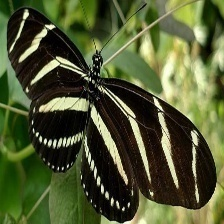

In [ ]:
#predicting images
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/test/Image_10.jpg'

img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # shape (1, h, w, 3)
img_array /= 255.0  # rescale like training


pred = model.predict(img_array)
predicted_index = np.argmax(pred)
predicted_label = class_ind[predicted_index]

print(predicted_label, pred[0][predicted_index]*100)
Image(img_path)

In [1]:
from tensorflow.keras.models import load_model

model = load_model('vgg16_butterfly_csv_model.h5')

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached wrapt-1.17.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 5.3 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━